## The (1,2,1) Hamiltonian

The electric and magnetic Hamiltonians in the (1,2,1) Hamiltonian are

$$ H_E =  g^2 \left( N_c - \frac{1}{N_c} \right)\left[ \sum_p  P_{1,p} - \frac{1}{2}\sum_p \sum_{\hat{n}} P_{1,p} P_{1,p+\hat{n}} \right] $$

$$ H_B = -\frac{1}{\sqrt{2}g^2} \sum_{p} \left( \prod_{\hat{n}} P_{0,p+\hat{n}} \right) X_p - \frac{1}{2g^2 N_c} \sum_{p} \sum_{\hat{k}} P_{1,p+\hat{k}} \left( \prod_{\hat{n}\neq\hat{k}} P_{0,p+\hat{n}} \right) X_p $$

where $P_0 = |0\rangle\langle 0|$ and $P_1 = |1\rangle\langle 1 |$, where the sum over $\hat{n}$ is a sum over lattice unit vectors.

In this truncation, a pair of neighboring plaquettes can be excited, with the link between the two plaquettes in the 1 representation.

In [655]:
import math
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy.sparse import kron, eye, csr_matrix
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import display, Math
from matplotlib.colors import ListedColormap

### Code for defining the Hamiltonian is here:

In [722]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Define functions that implements the operators in the Hamiltonian.
Want to work with sparse matrices.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

# Create the one-qubit operations
Id =  sparse.csr_matrix(np.array([[1.,0.],[0.,1.]]))
P1 = sparse.csr_matrix(np.array([[0., 0.],[0., 1.]]))
P0 = sparse.csr_matrix(np.array([[1.,0.],[0.,0.]]))
Xop = sparse.csr_matrix(np.array([[0.,1.],[1.,0.]]))


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
A function that acts with a one-qubit operator on a specified qubit. So, it takes in a 2x2 matrix and spits out a 2^n x 2^n matrix.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def one_qubit_gate( 
    M: sparse._csr.csr_matrix, 
    p: int, 
    n: int
    ) -> sparse._csr.csr_matrix:
    if (M.shape != (2,2)):
        print('Warning: Expected M argument to be a 2x2 sparse matrix.')
    if ( p<0 or p>=n ):
        print(f'Warning: Expected p argument to be within the range [0, {n}-1] inclusive.')
    result = eye(1, format='csr') # create a sparse 1x1 matrix to store result
    for i in range(n):
        if (i==p):
            result = kron(result, M, format='csr')
        else:
            result = kron(result, Id, format='csr')  
    return result


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    Define a function that returns an n-qubit gate that is in the form of a tensor product of single qubit gates.

    Expects the dictionary op_dict to be of the form { p1: M1, p2: M2, p3: M3 } where the p's are integers specifying
    qubits and the M's are 2x2 matrices in sparse format specifying one-qubit gates.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def multi_qubit_gate(
    op_dict: dict, 
    n: int
    ) -> sparse._csr.csr_matrix:
    result = eye(1, format='csr') # Create a 1x1 in sparse format to build our operator
    for i in range(n):
        if i in op_dict:
            result = kron(result, op_dict[i], format='csr')
        else:
            result = kron(result, Id, format='csr')
    return result


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Convert between the single-index p which enumerates qubits, and double-index (i,j) which enumerates lattice sites
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def map_to_circuit( i, j, L, H ):
    if i >= L:
        print(f"[map_to_circuit] i index out of bounds: expected i<{L}, but i={i}")
    if j >= H:
        print(f"[map_to_circuit] j index out of bounds, expected j<{H}, but j={j}")
        
    return j*L + i


def map_to_lattice( p, L, H ):
    if p >= (L*H):
        print(f"[map_to_lattice] p index out of bounds, expected p<{L*H}, but p={p}")

    return p % L, p // L



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''' 
Create a function that produces the Hamiltonian matrix
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def make_electric_ham(
    g: float, 
    lat_shape: list, 
    boundary: str = 'periodic', 
    N_colors: int = 3 
) -> sparse._csr.csr_matrix:
    
    # Returns a sparse 2**n x 2**n matrix containing the diagonal part of the Hamiltonian
    L = lat_shape[0]
    H = lat_shape[1]
    n = L*H
    
    H_E = csr_matrix((2**n, 2**n))
    
    for p in range(n):
        H_E += one_qubit_gate(P1, p, n)
        
    if boundary=='periodic':
        for p in range(n):
            i, j = map_to_lattice(p, L, H)
            nr   = map_to_circuit((i + 1) % L, j, L, H)
            nu   = map_to_circuit(i, (j + 1) % H, L, H)
            H_E -= 0.5 * multi_qubit_gate( {p: P1, nr: P1}, n )
            H_E -= 0.5 * multi_qubit_gate( {p: P1, nu: P1}, n )
        
    return (N_colors - 1/N_colors)*g*g * H_E



def make_magnetic_ham(
    g: float, 
    lat_shape: tuple, 
    boundary='periodic',
    N_colors: int = 3
) -> sparse._csr.csr_matrix:
    # Returns a sparse 2**n x 2**n matrix containing the magnetic part of the Hamiltonian
    L = lat_shape[0]
    H = lat_shape[1]
    n = L*H
    mag_prefactor1 = -np.sqrt(2)/(2*g*g)
    mag_prefactor2 = -1/(2*g*g*N_colors)

    H_B1 = csr_matrix((2**n, 2**n))
    H_B2 = csr_matrix((2**n, 2**n))
    
    if (boundary == 'periodic'):
        for p in range(n):
            i, j = map_to_lattice(p, L, H)
            nl   = map_to_circuit((i - 1) % L, j, L, H)
            nd   = map_to_circuit(i, (j - 1) % H, L, H)
            nr   = map_to_circuit((i + 1) % L, j, L, H)
            nu   = map_to_circuit(i, (j + 1) % H, L, H)

            # Apply the X P0 P0 P0 P0 term
            H_B1 += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P0, nu: P0}, n )

            # Apply the X P0 P0 P0 P1 term
            H_B2 += multi_qubit_gate( {p: Xop, nl: P1, nd: P0, nr: P0, nu: P0}, n )
            H_B2 += multi_qubit_gate( {p: Xop, nl: P0, nd: P1, nr: P0, nu: P0}, n )
            H_B2 += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P1, nu: P0}, n )
            H_B2 += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P0, nu: P1}, n )

    H_B = mag_prefactor1 * H_B1  +   mag_prefactor2 * H_B2
    
    return H_B


def make_ham(
    g: float, 
    lat_shape: tuple, 
    boundary: str ='periodic',
    N_colors: int =3
) -> sparse._csr.csr_matrix:
    
    HE = make_electric_ham(g, lat_shape, boundary, N_colors)
    HB = make_magnetic_ham(g, lat_shape, boundary, N_colors)
    return HE + HB


def get_ground_state_energy(g, lat_shape, boundary='periodic', N_colors=3):
    H = make_ham(g, lat_shape, boundary, N_colors)
    evals, evecs = eigsh( H, which='SA', k=1)
    return evals[0]


### Code for drawing states is here:

In [728]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Take in a string like "0001001000" specifying a computational basis state |0001001000>, and the lattice shape (L,H),
and plot the state.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def write_state_as_kets( vec, max_num_states=10 ):
    # Get the number of qubits from the length of the vector
    n = int(np.log2(len(vec)))

    # Trim the vector down to its k largest (absolute) values
    vec = keep_k_largest(vec, k=max_num_states)
    
    # Make a list of tuples of the form (coefficient, state) 
    terms = [ (vec[i], format(i, f"0{n}b") ) for i in range(len(vec)) if np.abs(vec[i]) > 0.00000001 ]
    # Sort them in descending order based on their coefficients
    terms = sorted( terms, key=lambda t: abs(t[0]), reverse=True )
    
    # Make this into a list of LaTeX formatted terms
    latex_terms = [ fr'{{{coef:.3f}}}\ket{{{state}}}' for coef, state in terms ]
    expr = " + ".join(latex_terms)
    
    # Write it
    display(Math(expr))
    return



def draw_state( vec, lat_shape, max_num_states=10 ):
    # Convert the lattice shape to an array shape
    arr_shape = (lat_shape[1], lat_shape[0])
    
    # Get the number of qubits from the lattice shape, and make sure the vector and lattice shapes are compatible
    L, H = lat_shape[0], lat_shape[1]
    n = L*H
    if n != int(np.log2(len(vec))):
        print(f"[draw_state]: The number of qubits in vec ({int(np.log2(len(vec)))}) and the lattice shape ({lat_shape}) are not compatible")

    # Trim the vector down to its k largest (absolute) values
    vec = keep_k_largest(vec, k=max_num_states)

    # Make a list of tuples of the form (coefficient, binary_string), sorted by size of coefficient
    terms = [ (vec[i], format(i, f"0{n}b") ) for i in range(len(vec)) if np.abs(vec[i]) > 0.0000001 ]
    terms = sorted( terms, key=lambda t: abs(t[0]), reverse=True )

    
    # Create side-by-side plots
    fig, axs = plt.subplots(1, len(terms), figsize=(len(terms)*1.5, 1.5))

    # Handle edge case
    if len(terms) == 1:
        axs = [axs]

    for ax, term in zip(axs, terms):
        create_binary_plot_on_ax(ax, term[1], arr_shape)

    plt.tight_layout()
    plt.show()
    return





def create_binary_plot(binary_str, lat_shape, borders=True):
    # Start by converting the binary string into a binary array
    binary_array = binary_array_from_list( binary_str, lat_shape )
    
    # Create custom colormap
    cmap = ListedColormap(["#003366", "#FFD700"])

    # Create the plot
    fig, ax = plt.subplots(figsize=(lat_shape[0], lat_shape[1]))
    im = ax.imshow(binary_array, cmap=cmap, interpolation="none", vmin=0, vmax=1)

    # Style the plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

    # Optional: add gridlines if you want to see borders
    if borders==True:
        plt.grid(color='white', linewidth=1)
        plt.gca().set_xticks(np.arange(-.5, lat_shape[0], 1), minor=True)
        plt.gca().set_yticks(np.arange(-.5, lat_shape[1], 1), minor=True)
        plt.gca().grid(which="minor", color="white", linewidth=2)
        plt.gca().tick_params(which="minor", bottom=False, left=False)

    plt.close(fig)  # 👈 prevent automatic display

    # Return the figure and axis for later use
    return fig, ax



'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Helper functions below
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


# Helper function, to turn a binary string into an array with the shape of the lattice
def binary_array_from_list( binary_str: str, lat_shape: tuple):
    arr_shape = (lat_shape[1], lat_shape[0])

    # Convert the string into a list of integers (0s and 1s)
    binary_list = [int(bit) for bit in binary_str]

    # Convert the list into a NumPy array with the desired shape
    binary_array = np.array(binary_list).reshape(arr_shape)

    return binary_array


# The create_binary_plot function, now slightly tweaked to draw on an Axes object
# Helper function for draw_state()
def create_binary_plot_on_ax(ax, binary_str, shape):
    binary_array = np.array([int(b) for b in binary_str]).reshape(shape)
    cmap = ListedColormap(["#003366", "#FFD700"])
    ax.imshow(binary_array, cmap=cmap, interpolation="none", vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

    
# Helper function, trip an array to only its k largest values
def keep_k_largest(arr, k):
    # Make a copy so we don't modify the original
    result = np.zeros_like(arr)
    
    # Get indices of the k largest absolute values
    if k > 0:
        idx = np.argpartition(np.abs(arr), -k)[-k:]
        result[idx] = arr[idx]
    
    return result




#'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#Old code below
#'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


# '''
# Takes in a string like "0001001000" specifying a computational basis state |0001001000>, and spits out the corresponding
# vector of length 2^n. This vector will be a "one shot" vector, with only a single nonzero entry (which will
# be equal to 1).

# Also write an inverse function, mapping oneshot vectors to basis state strings.
# '''

#def show_ket(bitstring):
#    from IPython.display import display, Math
#    display(Math(fr'\ket{{{bitstring}}}'))

    

# def list_to_oneshot_vector(config: str):
#     n = len(config)
#     vec = np.zeros(2**n)
#     vec[int(config, 2)] = 1
#     return vec


# def oneshot_vector_to_list(vec: np.ndarray) -> str:
#     index = np.argmax(vec)  # gets the index where the 1 is
#     n = int(np.log2(len(vec)))  # number of bits in the original string
#     binary_str = format(index, f"0{n}b")  # convert to binary and pad with zeros
#     return binary_str


### Unphysically degenerate electric vacuum

The new electric Hamiltonian nominally has a degenerate ground state, as can be seen by diagonalizing it and printing the two lowest energies:

In [679]:
g = 1.
lat_shape = (3,3)

H = make_electric_ham(g, lat_shape)
evals, evecs = eigsh(H, k=10, which='SA')

print(f"The two lowest energies are {evals[0]:.{4}f} and {evals[1]:.{4}f}.")

The two lowest energies are 0.0000 and 0.0000.


One of these states is the physical electric vacuum $|00...0\rangle$. The other one is the state $|11...1\rangle$, which at first glance appears to be a maximally excited state. However, it has no meaning within this truncation scheme, because it allows more than two nieghboring plaquettes to be excited (in this case, all of them). The interaction term $\sim P_1 P_1$ in the electric Hamiltonian is attractive, and with just the right prefactor to cause the electric energy of the $|11...1\rangle$ state to vanish. However, the dyanmics does not couple to this state, and with proper error mitigation this unphysical state should not show up at all in practice.

In [733]:
# See the two ground state eigenvectors explicitly:
g = 1.
lat_shape = (3,3)

H = make_electric_ham(g, lat_shape)
evals, evecs = eigsh(H, k=2, which='SA')

print("The first (degenerate) electric vacuum is:")
write_state_as_kets(evecs[:,0] )
print("The second (degenerate) electric vacuum is:")
write_state_as_kets(evecs[:,1])

The first (degenerate) electric vacuum is:


<IPython.core.display.Math object>

The second (degenerate) electric vacuum is:


<IPython.core.display.Math object>



### Magnetic hamiltonian spectrum as a function of coupling

Diagonzalization up to g= 0.4  complete.
Diagonzalization up to g= 0.5  complete.
Diagonzalization up to g= 0.6  complete.
Diagonzalization up to g= 0.7  complete.
Diagonzalization up to g= 0.8  complete.
Diagonzalization up to g= 0.9  complete.
Diagonzalization up to g= 1.0  complete.
Diagonzalization up to g= 1.1  complete.
Diagonzalization up to g= 1.2  complete.


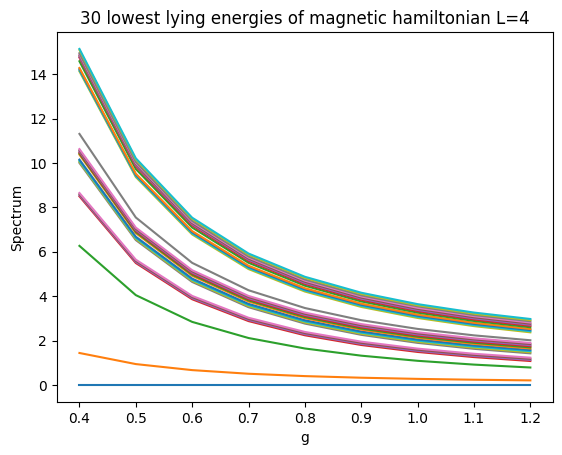

In [226]:
lat_shape = (4,4)
gvals = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2])

num_evals = 20

energies = []

for i in range(len(gvals)):
    g = gvals[i]
    h = make_magnetic_ham(g, lat_shape)
    evals, evecs = eigsh( h, which='SA', k=num_evals )
    energies.append(evals)
    print("Diagonzalization up to g=", g, " complete.")

#Make plots
fig, ax = plt.subplots()

plt.title(f"{num_evals} lowest lying energies of magnetic hamiltonian L={lat_shape[0]}") 
plt.xlabel("g") 
plt.ylabel("Spectrum")

offset=0.05

for k in range(num_evals):
    ax.plot( gvals, [i[k]-i[0]+k*offset for i in energies] ,'-')

plt.show()

## Spectrum as a function of coupling

In [257]:
lat_shape = (3,3)
gvals = np.linspace(0.65, 1.05, 20)
boundary = "periodic"

num_evals = 100

energies = []

for i in range(len(gvals)):
    g = gvals[i]
    h = make_ham(g, lat_shape, boundary)
    evals, evecs = eigsh( h, which='SA', k=num_evals )
    energies.append(evals)
    print("Diagonzalization up to g=", g, " complete.")

Diagonzalization up to g= 0.65  complete.
Diagonzalization up to g= 0.6710526315789473  complete.
Diagonzalization up to g= 0.6921052631578948  complete.
Diagonzalization up to g= 0.7131578947368421  complete.
Diagonzalization up to g= 0.7342105263157895  complete.
Diagonzalization up to g= 0.7552631578947369  complete.
Diagonzalization up to g= 0.7763157894736843  complete.
Diagonzalization up to g= 0.7973684210526316  complete.
Diagonzalization up to g= 0.8184210526315789  complete.
Diagonzalization up to g= 0.8394736842105264  complete.
Diagonzalization up to g= 0.8605263157894737  complete.
Diagonzalization up to g= 0.881578947368421  complete.
Diagonzalization up to g= 0.9026315789473685  complete.
Diagonzalization up to g= 0.9236842105263159  complete.
Diagonzalization up to g= 0.9447368421052631  complete.
Diagonzalization up to g= 0.9657894736842105  complete.
Diagonzalization up to g= 0.986842105263158  complete.
Diagonzalization up to g= 1.0078947368421054  complete.
Diagonza

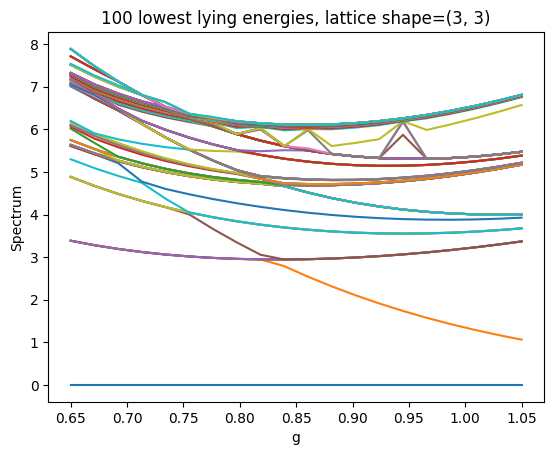

In [259]:
#Make plots
fig, ax = plt.subplots()

plt.title(f"{num_evals} lowest lying energies, lattice shape={lat_shape[0], lat_shape[1]}") 
plt.xlabel("g") 
plt.ylabel("Spectrum")

offset=0.0

for k in range(num_evals):
    ax.plot( gvals, [i[k]-i[0]+k*offset for i in energies] ,'-')

plt.show()

In [313]:
n=6
zero = np.array([1.,0.])
one = np.array([0.,1.])

config = "111111"

mydict = {"0": zero, "1": one}

psi = np.array([1.])

for i in range(n):
    psi = np.kron( psi, mydict[config[i]] )

psi

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

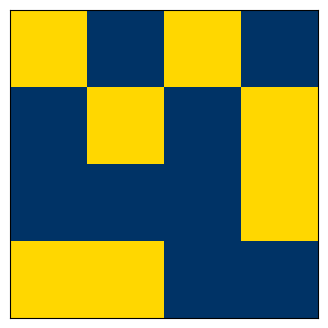

In [471]:
fig, ax = create_binary_plot("1010010100011100", (4, 4), borders=False)
display(fig)

<IPython.core.display.Math object>

In [735]:
g = 1.
lat_shape = (3,3)

H = make_ham(g, lat_shape)
evals, evecs = eigsh(H, k=10, which='SA')

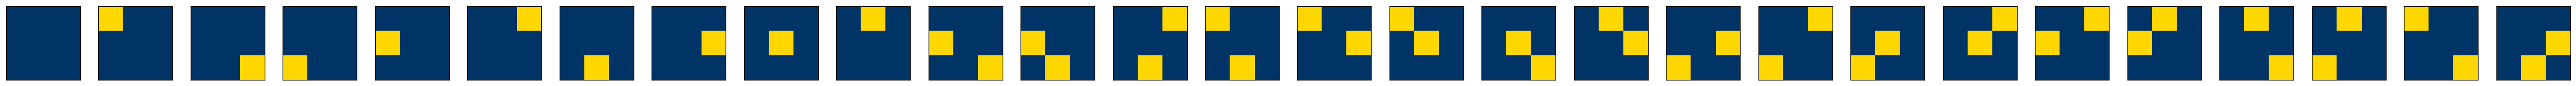

In [737]:
ground_state = evecs[:,0]

draw_state( ground_state , (3,3), 28 )

In [738]:
write_state_as_kets( ground_state, 28 )

<IPython.core.display.Math object>